<a href="https://colab.research.google.com/github/FaisalAhmed0/machine_learning_from_scratch/blob/main/Faisal_Mohamed_Implement_a_multi_layer_perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nueral Networks (MLP)
This notebook implemenets a single hidden layer neural network from the scratch usng only pytorch vector operations, optimizationn is done with batch gradient descent

## Data Downloading and shape adjustments

In [ ]:
import torch
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
RANDOM_SEED = 1

def convert_to_one_hot_labels(input, target):
    tmp = input.new_zeros(target.size(0), target.max() + 1)
    tmp.scatter_(1, target.view(-1, 1), 1.0)
    return tmp

def load_data(cifar = None, one_hot_labels = False, normalize = False, flatten = True, data_dir="./"):
    if cifar is not None and cifar:
        print('* Using CIFAR')
        cifar_train_set = datasets.CIFAR10(data_dir + '/cifar10/', train = True, download = True, transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
        cifar_test_set = datasets.CIFAR10(data_dir + '/cifar10/', train = False, download = True)

        train_input = torch.from_numpy(cifar_train_set.data)
        train_input = train_input.transpose(3, 1).transpose(2, 3).float()
        train_target = torch.tensor(cifar_train_set.targets, dtype = torch.int64)

        test_input = torch.from_numpy(cifar_test_set.data).float()
        test_input = test_input.transpose(3, 1).transpose(2, 3).float()
        test_target = torch.tensor(cifar_test_set.targets, dtype = torch.int64)

    else:
        print('* Using MNIST')
        mnist_train_set = datasets.MNIST('./', train = True, download = True)
        mnist_test_set = datasets.MNIST('./', train = False, download = True)

        train_input = mnist_train_set.data.view(-1, 1, 28, 28).float()
        train_target = mnist_train_set.targets
        test_input = mnist_test_set.data.view(-1, 1, 28, 28).float()
        test_target = mnist_test_set.targets

    train_input = train_input.narrow(0, 0, 1000)
    train_target = train_target.narrow(0, 0, 1000)
    test_input = test_input.narrow(0, 0, 1000)
    test_target = test_target.narrow(0, 0, 1000)

    if flatten:
        train_input = train_input.clone().reshape(train_input.size(0), -1)
        test_input = test_input.clone().reshape(test_input.size(0), -1)

    print('** Use {:d} train and {:d} test samples'.format(train_input.size(0), test_input.size(0)))

    if one_hot_labels:
        train_target = convert_to_one_hot_labels(train_input, train_target)
        test_target = convert_to_one_hot_labels(test_input, test_target)

    if normalize:
        mu, std = train_input.mean(), train_input.std()
        train_input.sub_(mu).div_(std)
        test_input.sub_(mu).div_(std)

    return train_input, train_target, test_input, test_target

######################################################################

def mnist_to_pairs(nb, input, target):
    input = torch.functional.F.avg_pool2d(input, kernel_size = 2)
    a = torch.randperm(input.size(0))
    a = a[:2 * nb].view(nb, 2)
    input = torch.cat((input[a[:, 0]], input[a[:, 1]]), 1)
    classes = target[a]
    target = (classes[:, 0] <= classes[:, 1]).long()
    return input, target, classes

######################################################################

def generate_pair_sets(nb):
    if args.data_dir is not None:
        data_dir = args.data_dir
    else:
        data_dir = os.environ.get('PYTORCH_DATA_DIR')
        if data_dir is None:
            data_dir = './data'

    train_set = datasets.MNIST(data_dir + '/mnist/', train = True, download = True)
    train_input = train_set.data.view(-1, 1, 28, 28).float()
    train_target = train_set.targets

    test_set = datasets.MNIST(data_dir + '/mnist/', train = False, download = True)
    test_input = test_set.data.view(-1, 1, 28, 28).float()
    test_target = test_set.targets

    return mnist_to_pairs(nb, train_input, train_target) + \
           mnist_to_pairs(nb, test_input, test_target)

######################################################################

In [ ]:
# Load the CIFAR datasey
train_input, train_target, test_input, test_target = load_data(True, True, True, True)

* Using CIFAR



Extracting .//cifar10/cifar-10-python.tar.gz to .//cifar10/
Files already downloaded and verified
** Use 1000 train and 1000 test samples


In [ ]:
# sample size
train_input.shape

torch.Size([1000, 3072])

## Implementing nerual networks methods

In this task we will use the mean square error \\
\begin{equation}
MSE = \frac{1}{N} \sum_i^N (\hat{y}_i - y_i)^2
\end{equation}

In [ ]:
# Loss Function and its dervative
def loss(predictions, targets):
  '''
  loss(v, t)
  This is the mean square error for regression problems.
  predictions: predicted values generated by the network. 
  targets: the ground truth targets
  '''
  return ((predictions - targets)**2).mean()

def dloss(predictions, targets):
  '''
  dloss(predictions, targets)
  This is the derivative of mean square error for regression problems.
  predictions: predicted values generated by the network. 
  targets: the ground truth targets
  '''
  return (-2*(predictions - targets)).mean()

In [ ]:
# Initilize the network parameters
def initlize_parameters(n_input, n_hidden, n_output, random_state=RANDOM_SEED):
  '''
  initlize_parameters(n_input, n_hidden, n_output, random_state=RANDOM_SEED)
  This function initializes the weights and biases of a single layer neural network randomly from a normal distribution with zero mean and 10^-6 std.
  n_input: number of dimensions of the input.
  n_hidden: number of units of the hidden layer.
  n_output: number of dimensions of the output.
  random_state: random seed.
  Return  w1, b1, w2, b2.
  '''
  torch.manual_seed(RANDOM_SEED)
  w1 = torch.normal(0, 1e-6, size=(n_hidden, n_input))
  b1 = torch.normal(0, 1e-6, size=(n_hidden, 1))
  w2 = torch.normal(0, 1e-6, size=(n_output, n_hidden))
  b2 = torch.normal(0, 1e-6, size=(n_output, 1))
  return w1, b1, w2, b2

In [ ]:
# Forward Pass
def forward_pass(w1, b1, w2, b2, x):
  '''
  This function performs the forward pass given the weight and biases of each layer with the input.
  w1: weights of the hidden layer.
  b1: biases of the hidden layer.
  w2: weights of the output layer.
  b2: biases of the output layer.
  return a0, z1, a1, z2, a2
  a: the layer activation.
  z: the result of the weights multiplication and adding the bias.
  '''
  a0 = x
  z1 = w1 @ a0 + b1
  a1 = tanh(z1)
  z2 = w2 @ a1 + b2
  a2 = tanh(z2)
  return a0, z1, a1, z2, a2

# Gradient calculations
def compute_gradient(y_hat, y, w1, b1, w2, b2, a0, z1, a1, z2, a2):
  '''
  compute_gradient(y_hat, y, w1, b1, w2, b2, a0, z1, a1, z2, a2)
  This function computes the gradient with backpropagation.
  y_hat: network prediction.
  y: ground target.
  w1: weights of the hidden layer.
  b1: biases of the hidden layer.
  w2: weights of the output layer.
  b2: biases of the output layer.
  a0: input value.
  z1: the result of the weights multiplication and adding the bias in the first hidden layer.
  a1: activation of the hidden layer.
  a2: activation of the output layer.
  z2: the result of the weights multiplication and adding the bias in the output layer.
  return a grad dictionary that contains the gradient of weights and biases of all layers.
  '''
  m = y.shape[1]
  da2 = 2*a2 - y_train
  dz2 = da2 * dtanh(z2)
  dw2 = (1/m) * dz2 @ a1.t()
  db2 = (1/m) * torch.sum(dz2, axis=1, keepdims=True)

  da1 = w2.t() @ dz2
  dz1 = da1 * dtanh(z1)
  dw1 = (1/m) * dz1 @ a0.t()
  db1 = (1/m) * torch.sum(dz1, axis=1, keepdims=True)

  grads = {}
  grads['w1'] = dw1
  grads['b1'] = db1
  grads['w2'] = dw2
  grads['b2'] = db2
  return grads


def backward_pass(w1, b1, w2, b2, grads, lr=0.1):
  '''
  backward_pass(w1, b1, w2, b2, grads, lr=0.1)
  This function updates the weights and biases with gradient descent.
  w1: weights of the hidden layer.
  b1: biases of the hidden layer.
  w2: weights of the output layer.
  b2: biases of the output layer.
  grads: a dictionary that contains the gradient of weights and biases of all layers.
  lr: learning rate.
  return w1, b1, w2, b2
  '''
  w1 = w1 - lr * grads['w1']
  b1 = b1 - lr * grads['b1']
  w2 = w2 - lr * grads['w2']
  b2 = b2 - lr * grads['b2']
  return w1, b1, w2, b2
  


In [ ]:
X_train = train_input.t() # Take the transpose to work the neural net notation (d, number of examples)
X_test = test_input.t() # Take the transpose to work the neural net notation (d, number of examples)
y_train = train_target.t() * 0.9 # multiply by 0.9 so that the label are in the same of tanh function
y_test = test_target.t() * 0.9  # multiply by 0.9 so that the label are in the same of tanh function

# Initlize parameters values.
w1, b1, w2, b2 = initlize_parameters(3072, 50, 10)
# loss list to plot the loss with each epoch.
losses = []

# 1000 epoch
for i in range(1000):
  # pass the input forward through the network.
  a0, z1, a1, z2, a2 = forward_pass(w1, b1, w2, b2, X_train)
  # compute the gradients
  grads = compute_gradient(a2, y_train, w1, b1, w2, b2, a0, z1, a1, z2, a2)
  # update the weights
  w1, b1, w2, b2 = backward_pass(w1, b1, w2, b2, grads, lr=0.1/m)
  # append the loss to the list
  losses.append(loss(a2, y_train))

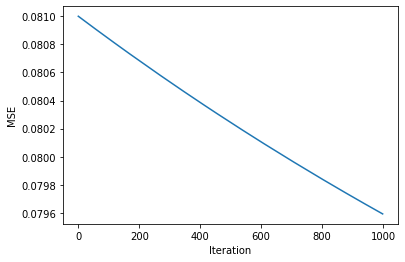

In [ ]:
# plot the learning error.
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.show()

In [ ]:
# Training error
print(f"Training error = {losses[-1]*100}%")
# Testing error
test_preds = forward_pass(w1, b1, w2, b2, X_test)[-1]
test_loss = loss(test_preds, y_test)
print(f"Testing error = {test_loss*100}%")

Training error = 7.959237098693848%
Testing error = 7.959589958190918%


## Putting all methods in a single class

In [ ]:
class Network:
  def __init__(self, nn_inputs, nn_hidden, n_outputs, lr=0.1, iterations=500):
    self.nn_inputs = nn_inputs
    self.nn_hidden = nn_hidden
    self.nn_outputs = n_outputs
    self.lr = lr
    self.iterations = iterations
    # initilize parameters
    self.initlize_parameters()

  def __call__(self, X):
    return self.forward_pass(X)

  def initlize_parameters(self):
    '''
    initlize_parameters(n_input, n_hidden, n_output, random_state=RANDOM_SEED)
    This function initializes the weights and biases of a single layer neural network randomly from a normal distribution with zero mean and 10^-6 std.
    n_input: number of dimensions of the input.
    n_hidden: number of units of the hidden layer.
    n_output: number of dimensions of the output.
    random_state: random seed.
    Return  w1, b1, w2, b2.
    '''
    torch.manual_seed(RANDOM_SEED)
    self.w1 = torch.randn(self.nn_hidden, self.nn_inputs)
    self.b1 = torch.randn(self.nn_hidden, 1)
    self.w2 = torch.randn(self.nn_outputs, self.nn_hidden)
    self.b2 = torch.randn(self.nn_outputs, 1)

  def forward_pass(self, X):
    '''
    This function performs the forward pass given the weight and biases of each layer with the input.
    w1: weights of the hidden layer.
    b1: biases of the hidden layer.
    w2: weights of the output layer.
    b2: biases of the output layer.
    return a0, z1, a1, z2, a2
    a: the layer activation.
    z: the result of the weights multiplication and adding the bias.
    '''
    self.a0 = X
    self.z1 = self.w1 @ self.a0 + self.b1
    self.a1 = self.tanh(self.z1)
    self.z2 = self.w2 @ self.a1 + self.b2
    self.a2 = self.tanh(self.z2)
    return self.a2

  # Gradient calculations
  def compute_gradient(self, y_train):
    '''
    compute_gradient(y_hat, y, w1, b1, w2, b2, a0, z1, a1, z2, a2)
    This function computes the gradient with backpropagation.
    y_hat: network prediction.
    y: ground target.
    w1: weights of the hidden layer.
    b1: biases of the hidden layer.
    w2: weights of the output layer.
    b2: biases of the output layer.
    a0: input value.
    z1: the result of the weights multiplication and adding the bias in the first hidden layer.
    a1: activation of the hidden layer.
    a2: activation of the output layer.
    z2: the result of the weights multiplication and adding the bias in the output layer.
    return a grad dictionary that contains the gradient of weights and biases of all layers.
    '''
    m = 1000
    da2 = 2*self.a2 - y_train
    dz2 = da2 * self.dtanh(self.z2)
    dw2 = (1/m) * dz2 @ self.a1.t()
    db2 = (1/m) * torch.sum(dz2, axis=1, keepdims=True)

    da1 = self.w2.t() @ dz2
    dz1 = da1 * self.dtanh(self.z1)
    dw1 = (1/m) * dz1 @ self.a0.t()
    db1 = (1/m) * torch.sum(dz1, axis=1, keepdims=True)

    grads = {}
    grads['w1'] = dw1
    grads['b1'] = db1
    grads['w2'] = dw2
    grads['b2'] = db2
    self.grads = grads

  def backward_pass(self):
    '''
    backward_pass(w1, b1, w2, b2, grads, lr=0.1)
    This function updates the weights and biases with gradient descent.
    w1: weights of the hidden layer.
    b1: biases of the hidden layer.
    w2: weights of the output layer.
    b2: biases of the output layer.
    grads: a dictionary that contains the gradient of weights and biases of all layers.
    lr: learning rate.
    return w1, b1, w2, b2
    '''
    self.w1 = self.w1 - self.lr * self.grads['w1']
    self.b1 = self.b1 - self.lr * self.grads['b1']
    self.w2 = self.w2 - self.lr * self.grads['w2']
    self.b2 = self.b2 - self.lr * self.grads['b2']

  def fit(self, X, Y):
    '''
    fit(X, Y)
    This function train the network parameters to optimize the loss.
    X: batch of inputs.
    Y: batch of outputs.
    return list of losses at each iterations.
    '''
    losses = []
    for i in range(self.iterations):
      y_hat = self.forward_pass(X)
      self.compute_gradient(Y)
      self.backward_pass()
      losses.append(self.loss(y_hat, Y))
    return losses

  # Activation Function and its dervative
  def tanh(self, x):
    return torch.tanh(x)

  def dtanh(self, x):
    return 1 - tanh(x)**2

  # Loss Function and its dervative
  def loss(self, v, t):
    '''
    loss(v, t)
    This is the mean square error for regression problems.
    predictions: predicted values generated by the network. 
    targets: the ground truth targets
    '''
    return ((t - v)**2).mean()

  def dloss(self, v, t):
    '''
    dloss(predictions, targets)
    This is the derivative of mean square error for regression problems.
    predictions: predicted values generated by the network. 
    targets: the ground truth targets
    '''
    return (-2*(t - v)).mean()


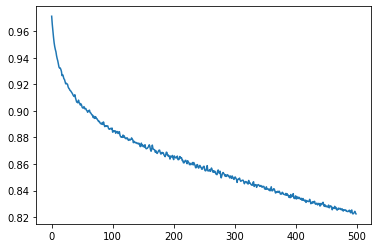

In [ ]:
net = Network(3072, 50, 10) # create a network object.
losses = net.fit(X_train, y_train) # fit the network.
# plot the training loss
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.show()

In [ ]:
# make a prediction 
net(X_test)

tensor([[-0.9631,  0.8642,  1.0000,  ...,  0.9999, -0.9996, -0.3264],
        [-1.0000,  0.0956,  1.0000,  ...,  0.9999, -1.0000,  0.9743],
        [-1.0000, -0.6086,  1.0000,  ...,  1.0000, -0.8404, -0.4920],
        ...,
        [-1.0000, -0.9197, -0.7683,  ...,  1.0000, -1.0000,  0.9535],
        [-0.9056,  0.9295, -0.7877,  ...,  0.9868, -0.9999,  0.8018],
        [-0.7808,  1.0000,  0.8776,  ..., -1.0000, -0.9576,  1.0000]])